In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 20
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
#D = V.copy()
D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
D_train = torch.from_numpy(D_train).float()
D_test = torch.from_numpy(D_test).float().to(device)

#D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
#D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
#D_train = D[:980].float()
#D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

1461


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V, batch_D)
    loss = torch.mean((S_out - batch_S)**2)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-c0b0dca94fca>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/9800 [00:00<?, ?it/s]

0 -0.005626678466796875 0.5841488838195801
49 0.026134192943572998 0.8353586196899414
99 0.05511218309402466 1.0948123931884766
149 0.07594341039657593 1.0759902000427246
199 0.13230544328689575 1.0838921070098877
249 0.02034085988998413 1.0896327495574951
299 0.029901206493377686 1.087900161743164
349 0.035890400409698486 1.0805296897888184
399 0.043098628520965576 1.0828800201416016
449 0.0561906099319458 1.0752122402191162
499 0.0890842080116272 1.0870401859283447
549 0.13362056016921997 1.0734336376190186
599 0.018870294094085693 1.092557430267334
649 0.024943411350250244 1.0898995399475098
699 0.03110647201538086 1.0855231285095215
749 0.03740370273590088 1.0970335006713867
799 0.04522979259490967 1.0800812244415283
849 0.05922156572341919 1.0774028301239014
899 0.08014911413192749 1.0773637294769287
949 0.11046868562698364 1.081277847290039
999 0.13402801752090454 1.0794422626495361
1049 0.16835051774978638 1.090014934539795
1099 0.1760314702987671 1.0999929904937744
1149 0.17531

9499 0.28899264335632324 1.07669997215271
9549 0.29045385122299194 1.0801165103912354
9599 0.2842708230018616 1.0728175640106201
9649 0.25936341285705566 1.0687217712402344
9699 0.2786661386489868 1.0844905376434326
9749 0.2863737940788269 1.085726261138916
9799 0.2753645181655884 1.0882797241210938


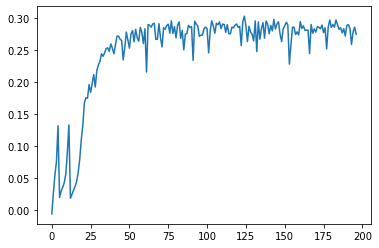

In [7]:
plt.plot(np.asarray(score_list))

(-1.0, 10.0)

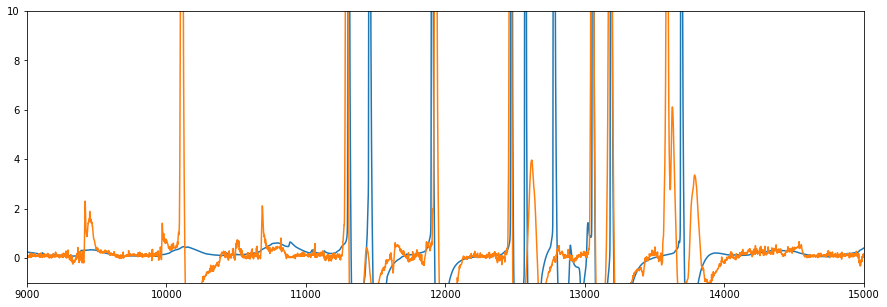

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(9000,15000)
plt.ylim(-1,10)

In [ ]:
np.save()